In [2]:

import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data
import photometric_cut
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

In [284]:
# Load binning info

path = "/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-16-58-46/bin_settings.txt"
with open(path, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']


In [285]:
# Load sampler info

sampler_path = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-16-58-46/sampler_2022-06-20-16-58-46.h5'
reader = emcee.backends.HDFBackend(sampler_path, read_only=True)
samples_data = reader.get_chain(discard=250)
flatchain = reader.get_chain(flat=True, discard = 250)

xdf = [num for num in range(0, samples_data.shape[2], 1)]
theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]

Sampler shape: (1500, 50, 5)


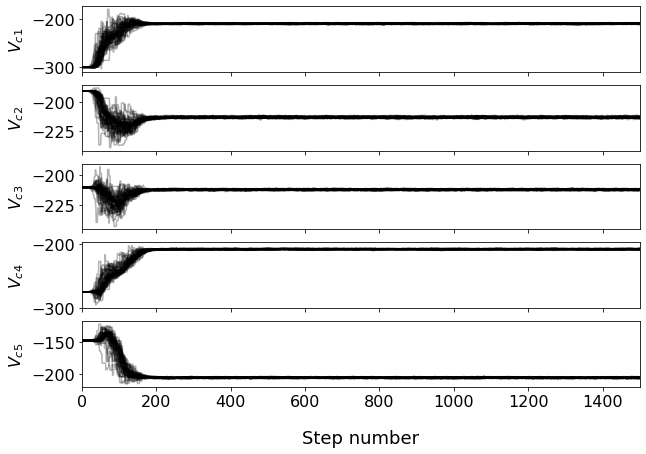

In [286]:
plot_walkers(reader, theta_labels)

(62500, 5)


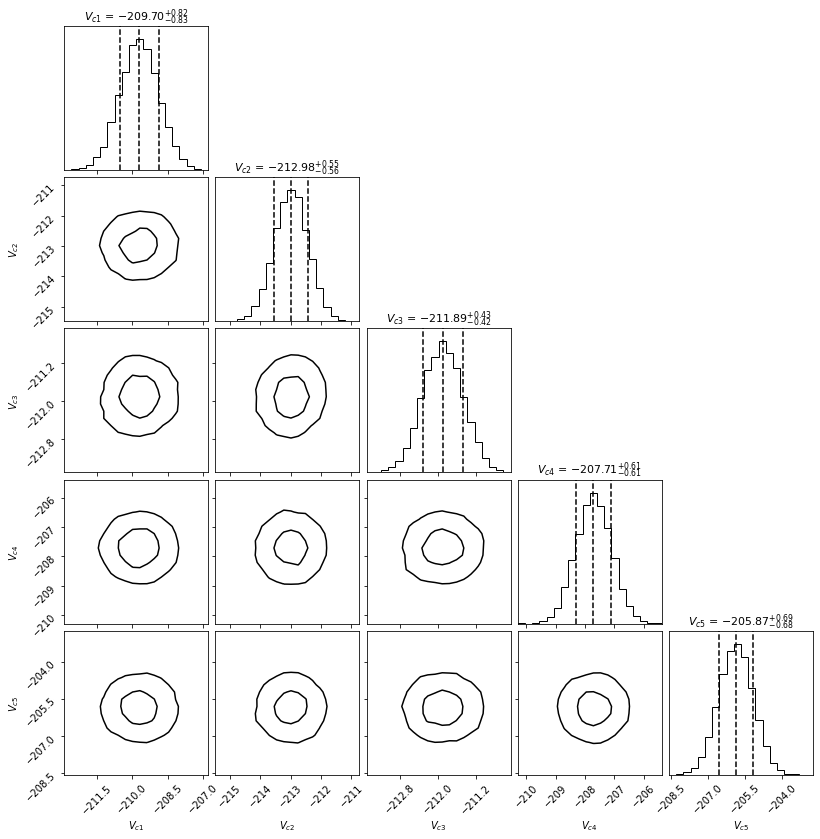

In [287]:
plot_corner(reader, theta_labels, burn_in=250)

In [288]:
bin_velocities = []
ndim = samples_data.shape[2]
for i in range(ndim):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    q = np.diff(mcmc)

    v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 

    bin_velocities.append((v_mean, v_sub, v_sup))

velocity_array = np.array(bin_velocities)


In [49]:
from pylab import *
from scipy.optimize import curve_fit

def plot_rotation_curve(is_fit_curve, mcmc_runs, labels, burnin):

    def func(x, a, b, c, ):
        return a*x*x + b*x + c

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'orange', 'blue']
    for i_path, path in enumerate(mcmc_runs):
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin)
        flatchain = reader.get_chain(flat=True, discard = burnin)

        bin_velocities = []
        ndim = samples_data.shape[2]
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            bin_velocities.append((v_mean, v_sub, v_sup))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
        else:
            x_offset = [-100, 0, 100]

        x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]

        plt.scatter(x_values, -y_values)

        y_error = [velocity_array[:,1], velocity_array[:,2]]
        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt='o')  

        if(is_fit_curve):
            popt, pcov = curve_fit(func, x_values, -y_values, sigma=velocity_array[:,1])
            perr = np.sqrt(np.diag(pcov))
            fit = func(np.array(x_values), popt[0], popt[1], popt[2])
            plot(x_values, fit, colors[i_path], lw=2, linestyle="-", alpha=0.75, label=labels[i_path])

        # popt_up = popt + 1*perr
        # popt_dw = popt - 1*perr
        # fit_up = func(np.array(x_values), *popt_up)
        # fit_dw = func(np.array(x_values), *popt_dw)
        # ax.fill_between(x_values, 
        #                 fit_up,
        #                 fit_dw, color='gray', alpha=.25)

    plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]
    bin_edges_z = bin_setup['bin_edges'][1].T[0]

    ax.vlines(bin_edges_r, -np.min(y_values) + 1, -np.max(y_values) - 1, linestyles='dashed', alpha=0.5, colors='grey')
    ax.set_xticks(np.round(bin_edges_r))

    r_range = r', $r \in [{},{}]$ kpc'.format(np.round(bin_edges_r[0]/1000), np.round(bin_edges_r[-1]/1000))
    z_range = r', $z \in [{},{}]$ pc'.format(np.round(bin_edges_z[0]), np.round(bin_edges_z[-1]))

    plt.legend()
    plt.title('Rotation Curve' + r_range + z_range, fontsize=18, pad=12)
    plt.show()

No handles with labels found to put in legend.


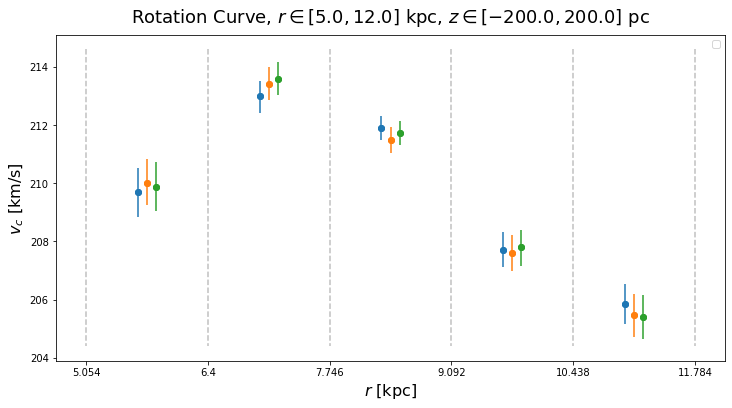

In [50]:
mcmc_runs = ['/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-18-09-19_range0.15/sampler_2022-06-20-18-09-19.h5',
            '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-18-12-50_range0.3/sampler_2022-06-20-18-12-50.h5',
            '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-18-16-29_range0.45/sampler_2022-06-20-18-16-29.h5']

input_path = "/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-20-16-58-46/bin_settings.txt"
with open(input_path, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

labels = ['cut range = 0.15', 'cut range = 0.3', 'cut range = 0.45']
plot_rotation_curve(False, mcmc_runs, labels, 250)


## Increased Binning

In [51]:
# Load binning info

path = "/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-21-10-00-16_range0.3/bin_settings.txt"
with open(path, 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']
print(bin_centers_r)

[ 5401.45068497  6095.55623508  6789.66178518  7483.76733529
  8177.8728854   8871.9784355   9566.08398561 10260.18953571
 10954.29508582 11648.40063593]


In [23]:
# Load sampler info

sampler_path = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-21-10-10-36_range0.3/sampler_2022-06-21-10-10-36.h5'
reader = emcee.backends.HDFBackend(sampler_path, read_only=True)
samples_data = reader.get_chain(discard=2200)
flatchain = reader.get_chain(flat=True, discard = 2200)

xdf = [num for num in range(0, samples_data.shape[2], 1)]
theta_labels = [r'$V_{c%s}$' %str(i+1) for i in xdf]

In [24]:
from IPython.display import display, Math
#theta_labels = ['U_{sun}','V_{sun}']
theta_labels = ['V_{c%s}' %str(i+1) for i in xdf]
for i in range(len(theta_labels)):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    
    q = np.diff(mcmc)
    
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], theta_labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Sampler shape: (3800, 50, 10)


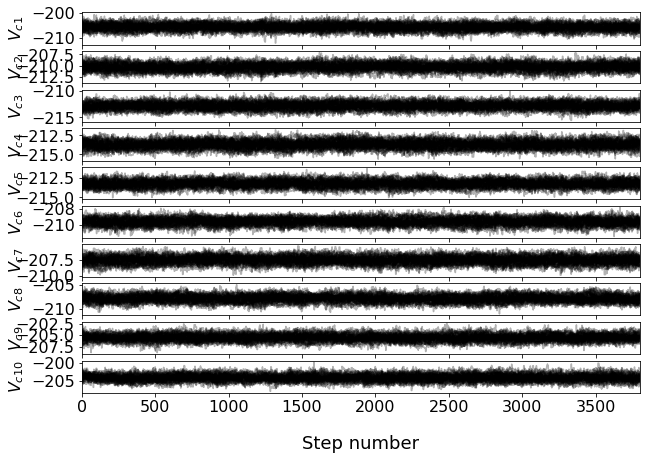

In [12]:
plot_walkers(reader, theta_labels, 2200)

(190000, 10)


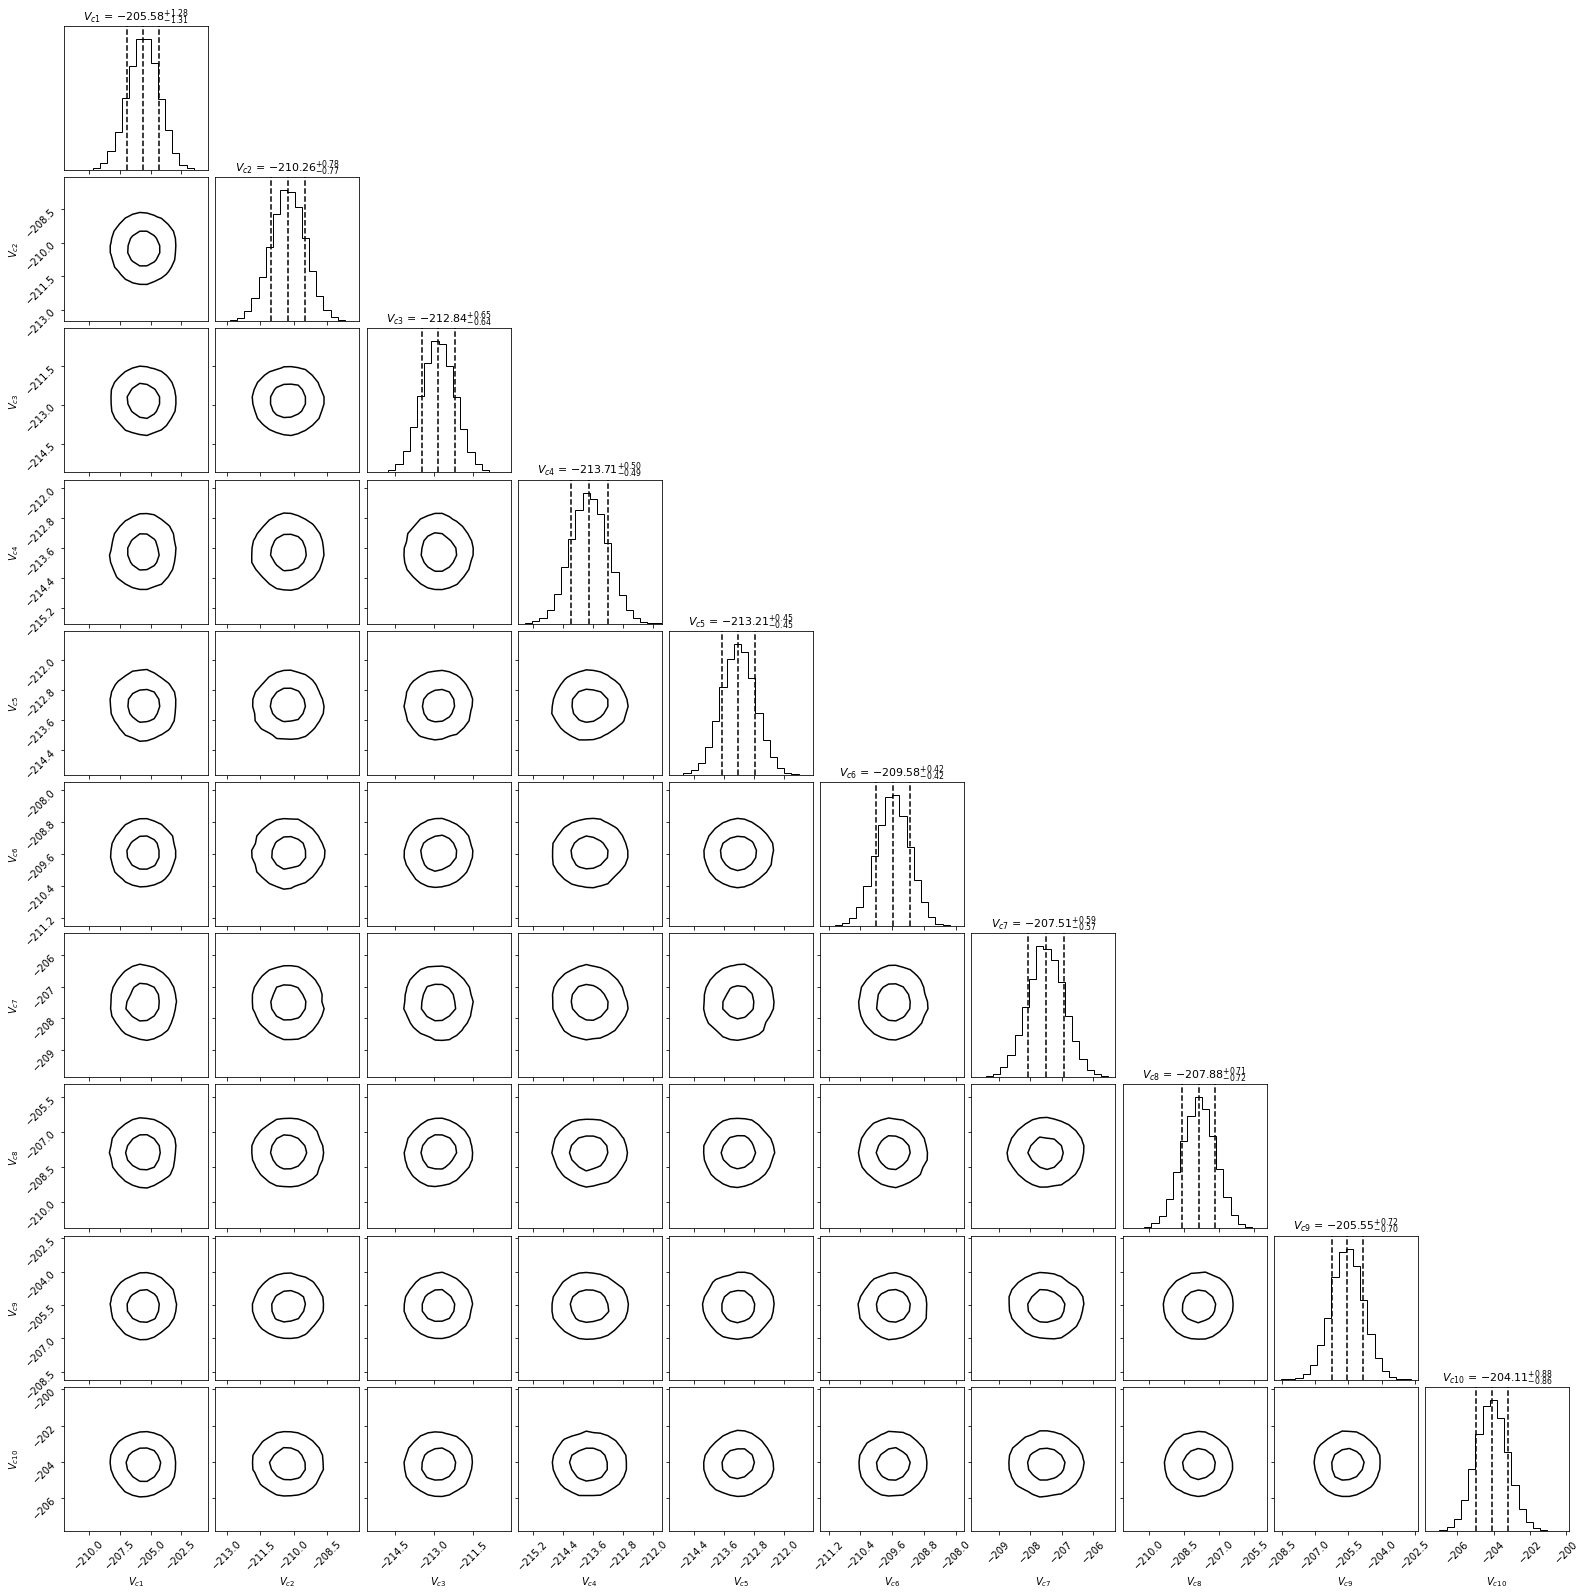

In [14]:
plot_corner(reader, theta_labels, 2200)

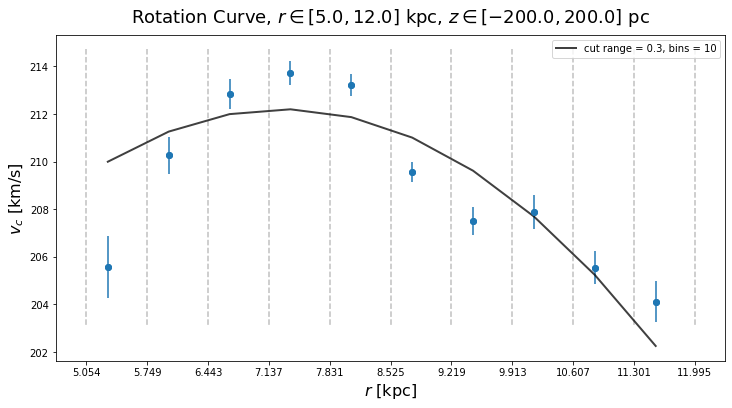

In [52]:
mcmc_runs = '/home/sven/repos/gaia-tools/out/mcmc_runs/2022-06-21-10-10-36_range0.3/sampler_2022-06-21-10-10-36.h5'
labels = ['cut range = 0.3, bins = 10']
plot_rotation_curve(True, [mcmc_runs], labels, 2200)

---